# **Customer Segmentation**

Customer Segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately.

The aim of this project is to helps Mandob Tuwiaq founders to understand their customers and applying different marketing approaches by build clustering models.

In [8]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set the plot style to a seaborn theme
plt.style.use("seaborn")
sns.set_style('white')
sns.set_palette("rocket",4)

## **Load Data**

In [9]:
# read data from the driver csv file
df = pd.read_excel(path, sheet_name='Orders')
df.sample(3)

,Id,Code,ReceivingLocationId,DeliveryLocationId,ReceivingDateTime,DeliveryDateTime,ProductDescription,ProductCategories,ProductPrice,Distance,Duration,DeliveryCost,Status,DriverId,CreatedDate,CreatedBy,PaymentByMe,IsOrderAccepted,IsPaid,OtherUserId,CollectedAmount,DriverCommissions,AppCommissions,RetailCollectedAmount,RegularDuration,DurationInTraffic
2315,3314,2317,5113.0,4977.0,2021-06-04 11:42:00,2021-06-04 11:15:00,كيك,Food,0,30070,1623,30,6,813.0,2021-06-04 04:20:37.523,183,1,1,0,5629,0,37,-7,0,1812,1623
1829,2828,1831,4346.0,4345.0,2021-05-12 21:11:00,2021-05-12 20:30:00,Bag,Other,0,36271,2499,30,6,141.0,2021-05-11 20:47:10.577,2473,0,1,1,1017,30,52,-22,0,2526,2499
2190,3189,2192,4935.0,4934.0,2021-06-01 11:50:00,2021-06-01 11:15:00,ساعه,Accessories,0,31582,2111,30,6,1172.0,2021-05-31 19:44:10.917,1357,1,1,1,5529,30,35,-5,0,2265,2111


### Fill missing values

In [10]:
# DeliveryLocationId and ReceivingLocationId
# 0 mean the loaction is empty 
df.DeliveryLocationId = df.DeliveryLocationId.fillna(0)
df.ReceivingLocationId = df.ReceivingLocationId.fillna(0)

# DeliveryDateTime and ReceivingDateTime 
# N/A mean DateTime not availble 
df.ReceivingDateTime = df.ReceivingDateTime.fillna('N/A')
df.DeliveryDateTime = df.DeliveryDateTime.fillna('N/A')

# DriverId
# 0 mean there isn't assigned Driver for this order
df.DriverId = df.DriverId.fillna(0)

# ProductDescription
df.ProductDescription = df.ProductDescription.fillna('Other')


## **Date Prepration**

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2604 entries, 0 to 2603
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Id                     2604 non-null   int64         
 1   Code                   2604 non-null   int64         
 2   ReceivingLocationId    2604 non-null   float64       
 3   DeliveryLocationId     2604 non-null   float64       
 4   ReceivingDateTime      2604 non-null   object        
 5   DeliveryDateTime       2604 non-null   object        
 6   ProductDescription     2604 non-null   object        
 7   ProductCategories      2604 non-null   object        
 8   ProductPrice           2604 non-null   int64         
 9   Distance               2604 non-null   int64         
 10  Duration               2604 non-null   int64         
 11  DeliveryCost           2604 non-null   int64         
 12  Status                 2604 non-null   int64         
 13  Dri

In [12]:
# read data from the driver csv file
df_users = pd.read_excel(path, sheet_name='Users')
df_users.sample(3)

,Id,AccountActive,UserActive,UserType,CreatedDate,FinancialAccount,IsUnderReviewed,IsDeleted,STCPay
1132,1294,-1,-1,2,2021-03-09 13:01:23.580,0.0,0,0,0
2348,2600,-1,-1,2,2021-04-18 01:35:54.993,0.0,0,0,0
4005,5278,-1,-1,2,2021-05-23 18:19:01.703,0.0,0,0,0


In [13]:
# read data from the driver csv file
df_payment = pd.read_excel(path, sheet_name='OrderPayment')
df_payment.sample(3)

,Id,TransactionDateTime,PaymentMode,MandoubakOrder_Id,IsValidStatus,UserId
1116,1120,2021-04-27 13:23:55.343,Cash,1172,0,0
1333,1337,2021-05-02 18:24:02.887,Card,1345,-1,2217
2640,3633,2021-06-03 15:09:04.793,Card,3294,0,0


In [14]:
# Merge Order with OrdersPayment 
df = df.rename(columns={"Code":"Order_Id"}) # rename 'Code' to Order_Id 
df_payment = df_payment.rename(columns={"MandoubakOrder_Id":"Order_Id"}) # rename 'MandoubakOrder_Id' to Order_Id 
df = df.merge(df_payment, on='Order_Id',how='left') # merge two dataframe based on the Order_Id
df.sample(2)

,Id_x,Order_Id,ReceivingLocationId,DeliveryLocationId,ReceivingDateTime,DeliveryDateTime,ProductDescription,ProductCategories,ProductPrice,Distance,Duration,DeliveryCost,Status,DriverId,CreatedDate,CreatedBy,PaymentByMe,IsOrderAccepted,IsPaid,OtherUserId,CollectedAmount,DriverCommissions,AppCommissions,RetailCollectedAmount,RegularDuration,DurationInTraffic,Id_y,TransactionDateTime,PaymentMode,IsValidStatus,UserId
2096,2696,1699,4124.0,4123.0,2021-05-09 20:00:00,2021-05-09 19:30:00,باقة ورد,Gift and flowers,0,26654,1821,30,6,2748.0,2021-05-09 13:22:36.433,2563,1,1,1,4774,30,43,-13,0,1868,1821,NaN,NaT,NaN,NaN,NaN
1283,1080,1078,1984.0,1983.0,2021-04-24 16:33:00,2021-04-24 16:00:00,منتجات ألف,Accessories,0,22669,1992,30,6,137.0,2021-04-24 03:55:39.980,1896,1,1,1,2908,0,47,-17,0,1749,1992,995.0,2021-04-24 00:15:08.633,Cash,0.0,2899.0


### **Buyer data preprocessing**

In [16]:
def Count_Order_Payment(df, group_by_column):
  """
  This function to count number of order based on each payment type
  
  Input:
    df: order data grouped by buyer ID

  Return:
    Cash, Card, StcPay: three lists, one for each payment method

  """
  Cash = df[df['PaymentMode'] == 'Cash'][['Order_Id']].groupby(group_by_column).count()
  Card = df[df['PaymentMode'] == 'Card'][['Order_Id']].groupby(group_by_column).count()
  StcPay = df[df['PaymentMode'] == 'STCPay'][['Order_Id']].groupby(group_by_column).count()
  return [Cash, Card, StcPay]


def Sum_PaymentByMe_Order(df, group_by_column):
  """
  This function to calculate total amount paid by buyer
  
  Input:
    df: order data grouped by buyer ID

  Return:
    total_payment: total amount paid by buyer

  """
  # calculate DeliveryCost paid buyer
  delivery = df[df['PaymentByMe'] == 1][['DeliveryCost']].groupby(group_by_column).sum()
  total_payment = delivery['DeliveryCost']

  return total_payment

We have two users in each order, order Creator and Receiver. In the following subsections, we do the pre-processing for each type (Creator and Receiver).

### **Preprocesse Creator data**

In [17]:
# find orders based on user type (buyers) and who creator for order.
# Than group orders by CreatorId
CreatorGroup = df[df['CreatedBy'].isin(df_users[df_users.UserType == 2]['Id'].values)].groupby('CreatedBy')

# convert CreatorGroup to dataframe 
CreatorGroup_df = CreatorGroup.apply(lambda a: a[:])

In [18]:
# create new dataframe with Count of orders for each buyer.
creator_df = pd.DataFrame(CreatorGroup.count()['Order_Id'])
# calculate total amount paid by buyer
creator_df['total_payment'] = Sum_PaymentByMe_Order(CreatorGroup_df, 'CreatedBy')
# count number of order based on each payment type
creator_df['Payment_Cash'] , creator_df['Payment_Card'] , creator_df['Payment_STCPay']  = Count_Order_Payment(CreatorGroup_df, 'CreatedBy') 
# find an unique prodcut categories ordered by buyer
creator_df['ProductCategories'] = [i for i in CreatorGroup['ProductCategories'].unique()]

creator_df.sample(2)

,Order_Id,total_payment,Payment_Cash,Payment_Card,Payment_STCPay,ProductCategories
CreatedBy,,,,,,
946,1,0.0,NaN,NaN,NaN,[Gift and flowers]
498,1,NaN,NaN,NaN,NaN,[Other]


### **Preprocesse Reciver data** 

In [20]:
# find orders based on user type (buyers) and who receive for order.
# Than group orders by OtherUserId
ReceiverGroup = df[df['OtherUserId'].isin(df_users[df_users.UserType == 2]['Id'].values)].groupby('OtherUserId')

# convert ReceiverGroup to dataframe 
ReceiverGroup_df = ReceiverGroup.apply(lambda a: a[:])


In [22]:
# create new dataframe with Count of orders for each buyer.
receiver_df = pd.DataFrame(ReceiverGroup.count()['Order_Id'])
# calculate total amount paid by buyer
receiver_df['total_payment'] = Sum_PaymentByMe_Order(ReceiverGroup_df, 'OtherUserId')
# count number of order based on each payment type
receiver_df['Payment_Cash'] , receiver_df['Payment_Card'] , receiver_df['Payment_STCPay']  = Count_Order_Payment(ReceiverGroup_df, 'OtherUserId') 
# find an unique prodcut categories ordered by buyer
receiver_df['ProductCategories'] = [i for i in ReceiverGroup['ProductCategories'].unique()]

receiver_df.sample(2)

,Order_Id,total_payment,Payment_Cash,Payment_Card,Payment_STCPay,ProductCategories
OtherUserId,,,,,,
3499,1,30.0,1.0,NaN,NaN,[Food]
3183,2,30.0,2.0,NaN,NaN,[Food]


### **Merge Creator and Receiver data on one dataframe**

In [23]:
# Merge creator and receiver data on one dataFrame
joined_Users = receiver_df.join(creator_df,lsuffix='_Receiver', rsuffix='_Creator' )
# fill missing values
joined_Users['ProductCategories_Creator'] = joined_Users['ProductCategories_Creator'].fillna('')
joined_Users = joined_Users.fillna(0)

In [26]:
joined_Users.sample(2)


,Order_Id_Receiver,total_payment_Receiver,Payment_Cash_Receiver,Payment_Card_Receiver,Payment_STCPay_Receiver,ProductCategories_Receiver,Order_Id_Creator,total_payment_Creator,Payment_Cash_Creator,Payment_Card_Creator,Payment_STCPay_Creator,ProductCategories_Creator
OtherUserId,,,,,,,,,,,,
1161,1,0.0,0.0,0.0,0.0,[Food],0.0,0.0,0.0,0.0,0.0,
4819,1,0.0,0.0,0.0,0.0,[Food],0.0,0.0,0.0,0.0,0.0,


In [27]:
# add creatore and receiver data together
joined_Users['Number_of_Orders'] = joined_Users['Order_Id_Receiver'] + joined_Users['Order_Id_Creator']
joined_Users['Total_Payment'] = joined_Users['total_payment_Receiver'] + joined_Users['total_payment_Creator']
joined_Users['Cash'] =  joined_Users['Payment_Cash_Receiver'] + joined_Users['Payment_Cash_Creator']
joined_Users['Card'] =  joined_Users['Payment_Card_Receiver'] + joined_Users['Payment_Card_Creator']
joined_Users['STC_Pay'] =  joined_Users['Payment_STCPay_Receiver'] + joined_Users['Payment_STCPay_Creator']

In [28]:
# find common product between ordered product, when buyer is creator and receiver
joined_Users['Common_ProdcutCat'] = [set(i).union(set(j)) for i, j in zip(joined_Users['ProductCategories_Receiver'], joined_Users['ProductCategories_Creator'])]

In [29]:
# find number of common product between ordered product, when buyer is creator and receiver
joined_Users['Common_ProdcutCat_Count'] = [len(i) for i in joined_Users['Common_ProdcutCat']]

In [30]:
# select columns from joined_Users
joined_Users = joined_Users[['Number_of_Orders', 'Total_Payment', 'Cash','Card','STC_Pay','Common_ProdcutCat_Count','Common_ProdcutCat']]
joined_Users.sample(2)

,Number_of_Orders,Total_Payment,Cash,Card,STC_Pay,Common_ProdcutCat_Count,Common_ProdcutCat
OtherUserId,,,,,,,
3627,2.0,60.0,1.0,1.0,0.0,1,{Gift and flowers}
4907,1.0,30.0,0.0,0.0,0.0,1,{Other}


## **Clustering model**


In [55]:
# import libraries
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [32]:
# take a copy from the joined_/users
cluster_df  = joined_Users.copy()

In [33]:
# merage the cluster_df with Users
cluster_df['Id'] = cluster_df.index
cluster_df = cluster_df.merge(df_users[['Id','UserActive']],on='Id')

## **Features Selection:**
In this step, we selected most affected features related to buyers, such as **`Number of Orders`**, **`Total amount paid by this buyer`**, **`Number of orders paid Cash`**, **`Number of Orders paid by Card`**, **`Number of orders paid using STCPay`** and **`Count of unique product categorical has ordered`**.


In [34]:
X= cluster_df[['Number_of_Orders', 'Total_Payment', 'Cash','Card','STC_Pay','Common_ProdcutCat_Count']]


In [35]:
X.sample(2)

,Number_of_Orders,Total_Payment,Cash,Card,STC_Pay,Common_ProdcutCat_Count
1036,1.0,30.0,0.0,0.0,0.0,1
1353,3.0,30.0,0.0,0.0,0.0,2


In [36]:
# Scale data
sc = StandardScaler()
X = sc.fit_transform(X)

## **Features reduction:** 
We decided to reduce number of features before training our models. We used PCA technique for features reduction process. First, we create a **Scree plot** to help us to select the best number of components for PCA. As below figure shows, the best number of components for our PCA is 3, because it's described at least 80% of the variance.


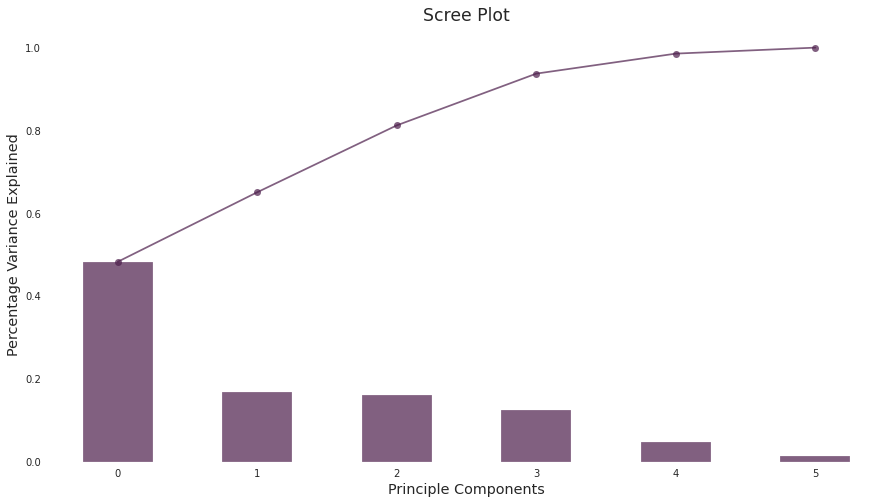

In [37]:
pca = PCA()
pca.fit(X)
sns.color_palette("YlOrBr", as_cmap=True)
plt.figure(figsize=(15,8))
exp_var = pd.Series(pca.explained_variance_ratio_) 
exp_var.plot(kind="bar", alpha=0.7) # plot bar chart

# Calculate the amount of variance explained added by each additional component
total = 0
var_ls = []
for x in exp_var:
    total = total+x
    var_ls.append(total)

pd.Series(var_ls).plot(marker="o", alpha=0.7) #plot line chart of increasing variances
plt.xlabel("Principle Components", fontsize="x-large")
plt.ylabel("Percentage Variance Explained", fontsize="x-large")
plt.title("Scree Plot", fontsize="xx-large")
plt.show();

In [38]:
# create PCA with 3 components
pca = PCA(n_components=3)
X = pca.fit_transform(X)

In [39]:
X

array([[ 1.70364841e+01,  3.82851520e+00,  7.25853338e+00],
       [-7.80252660e-01, -1.60020145e-01,  7.04674583e-03],
       [ 2.70370579e+00, -3.99720422e-01, -9.52413927e-02],
       ...,
       [-8.33081170e-03, -2.22439496e-01, -7.62564660e-02],
       [-2.78271571e-01, -2.03106595e-01, -3.69579251e-02],
       [-5.10311901e-01, -1.79353045e-01, -3.22517951e-02]])

## **Kmean:**
Now, we start build our clustering model using Kmean algorithm. The most important parmeter for Kmean algorithm is number of clusters. So, we should decide who many clusters we have in our data. There is many ways to select the best number of clusters for Kmean algorithm, in this project we applied two methods called **Elbow method** and **Silhouette Analysis method**.



### **1.Elbow method:**
Elbow is the common method used to determine the best value of K. This method calculates the variance between data points within a cluster using the Sum of Squared Error. The best value of k to select is the point of inflection on the curve. **As we see in the Elbow plot the best k for our model is 5.**


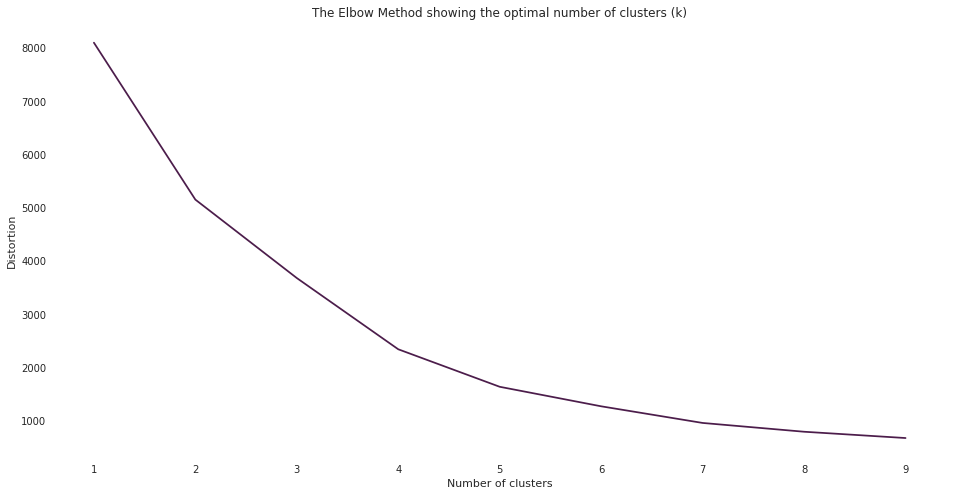

In [40]:
# Create Elbow Plot

w = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    w.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, w)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal number of clusters (k)')

plt.show()

### **2.Silhouette Analysis Method:**


This method calculates the average silhouette value for each data point in the cluster, this value represents how similar a data point is to its own cluster. The range of this measure from -1 to 1. A value of 1 means the sample is far away from the neighboring clusters.  The negative value refers to samples might have been as assigned to the wrong cluster. 


The next figure illustrates the idea of Silhouette Analysis Method, each row on the Silhouette plot represent one data point in the scatter plot and the X-axis refer to silhouette coefficient value. And the red line indicates to the average silhouette coefficient value for all samples in clusters.  The number clusters have a high silhouette coefficient value is the best to choose. Finally, from silhouette coefficient results we decide to choice **5 clusters**.


---


Resources:
1. https://www.coursera.org/lecture/build-regression-classification-clustering-models/silhouette-analysis-33ieO
2. https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


For n_clusters = 2 The average silhouette_score is : 0.9200125064644921
For n_clusters = 3 The average silhouette_score is : 0.829796171064892
For n_clusters = 4 The average silhouette_score is : 0.8598660634903628
For n_clusters = 5 The average silhouette_score is : 0.8625123864951525
For n_clusters = 6 The average silhouette_score is : 0.7083488454818586


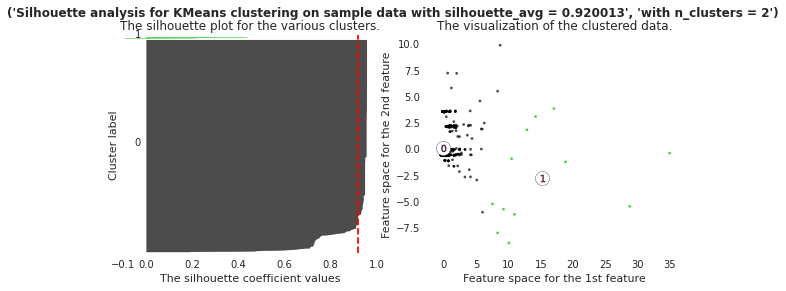

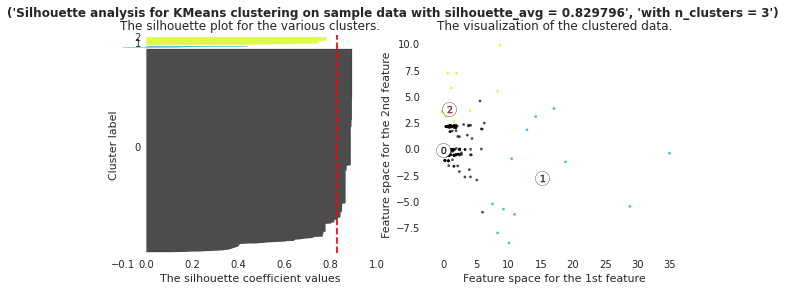

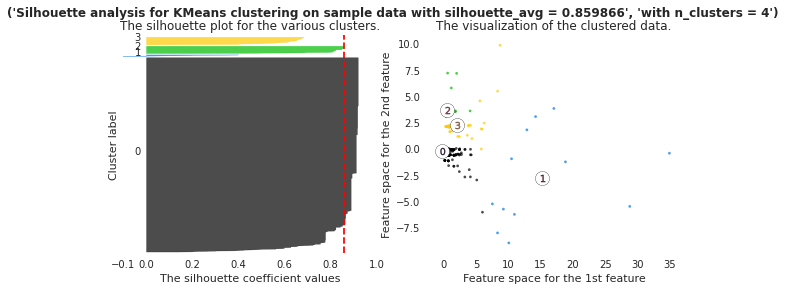

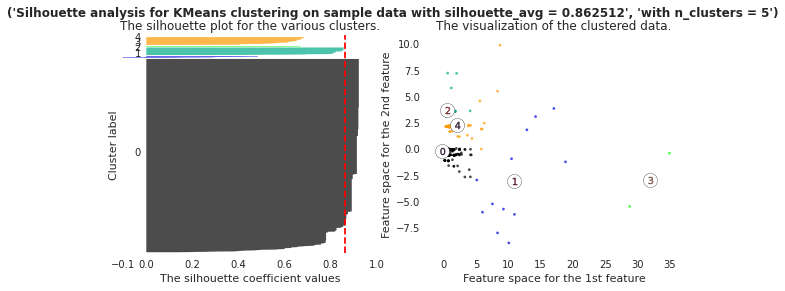

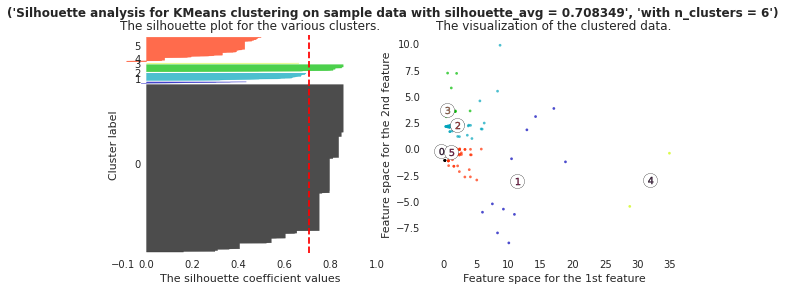

In [41]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with silhouette_avg = %f" % silhouette_avg,
                  "with n_clusters = %d" % n_clusters),
                 fontsize=12, fontweight='bold')


plt.show()

After applied Elbow and Silhouette Analysis methods, we built Kmean with 5 clusters.

In [42]:
# create a pipeline to scale data and 
# Apply KMeans 
kmean = KMeans(n_clusters=5)

kmean.fit(X)
y_pred = kmean.predict(X)
joined_Users['pred_cluster'] = y_pred

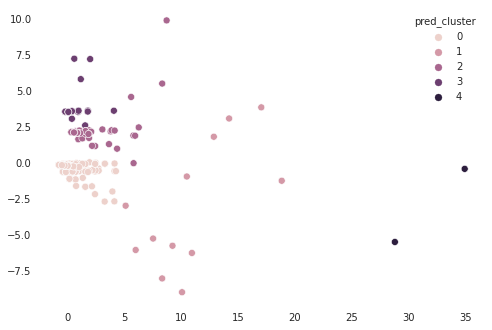

In [43]:
# Plot KMeans Results (2 dim)
sns.scatterplot(data = joined_Users, y= X[:,1], x= X[:,0], hue='pred_cluster');

In [44]:
# 3d Scatter plot of clusters using K-means
import plotly.express as px

fig = px.scatter_3d(X, x= X[:,0], y= X[:,1],z = X[:,2],
                  color=joined_Users['pred_cluster'], labels={'x':'Feature 1', 'y':'Feature 2','z':'Feature 3'} )
fig.show()

In [45]:
joined_Users.sample(2)

,Number_of_Orders,Total_Payment,Cash,Card,STC_Pay,Common_ProdcutCat_Count,Common_ProdcutCat,pred_cluster
OtherUserId,,,,,,,,
5460,1.0,30.0,0.0,0.0,0.0,1,{Beauty and care},0
5086,2.0,60.0,0.0,0.0,0.0,1,{Other},0


## **DBSCAN**

For detecting outliers and anomolies in our dataset DBSCAN(density-based spatial clustering of applications with noise) is the most productive.The two determinig parameters of dbcan are the eps and min_samples. 

The eps is the distance that determines a data point's  neighbor. Points are neighbors if the distance between them is less than or equal to eps. To determin the right value of eps 3 methods were used: sklearn's NearestNeighbors,k-distance elbow plot and an eps visulization.The optimal value for the eps is at the point of maximum curvature.

 The min_samples is the number of points to form a cluster .It is determined based on domain knowlege and how big or small a datset is. Given the number of dimensions of the dataset min_samples is chosen.A good rule of thumb is minPts >= D + 1 and since our dataset is 3D that makes min_sample=4.For larger datasets minPts >= D*2.  

  There are 3 main data points in dbscan the core point, border point and finally what dbscan is good at detecting the outlier point. The core points are points within the eps's radius. The border points are points that are accessible from the core points and with a less number of min_samples.An outlier is a point that isn't a core or a border point.  


DBSCAN Refrences:

 https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

https://towardsdatascience.com/dbscan-algorithm-complete-guide-and-application-with-python-scikit-learn-d690cbae4c5d

https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd

https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556

https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

https://towardsdatascience.com/how-dbscan-works-and-why-should-i-use-it-443b4a191c80


In [47]:
data_clus = X

# min_samples is selected based on our domain knowledge, 
# it's derived from the number of dimensions D and since our data is 3D and with 1662 records a rule of thumb for 3D datasets is to use minPts >= D + 1, min_samples = 4.
db=DBSCAN(eps=1, min_samples=4).fit(data_clus)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

#Even if we don't specify the number of cluster DBSCAN is good at detecting the number of clusters unlike k-means in which the number of clusters need to be specified. 
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [48]:
# add pred_cluster to joined_Users
joined_Users['pred_cluster_DBSCAN'] = labels

In [49]:
# set of clusters labels
set(labels)

{-1, 0, 1, 2, 3}

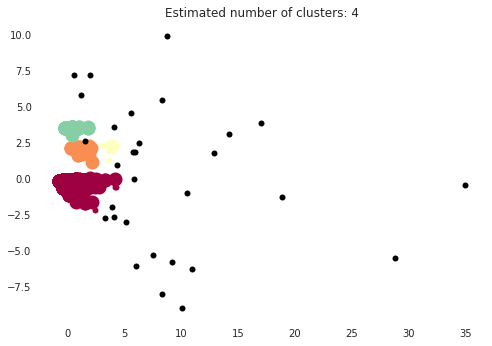

In [50]:
# Plot result
import matplotlib.pyplot as plt
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = data_clus[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = data_clus[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()


In [51]:
#3d Scatter plot of clusters using DBSCAN
fig = px.scatter_3d(X, x= X[:,0], y= X[:,1],z = X[:,2],
                  color=joined_Users['pred_cluster_DBSCAN'], labels={'x':'Feature 1', 'y':'Feature 2','z':'Feature 3'} )
fig.show()

In [52]:
#Number of outliers
db.labels_[db.labels_ == -1].size

30

### **Epsilion Visulization Graph:**

1.0
0.5
0.3333333333333333


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



0.25
0.2


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



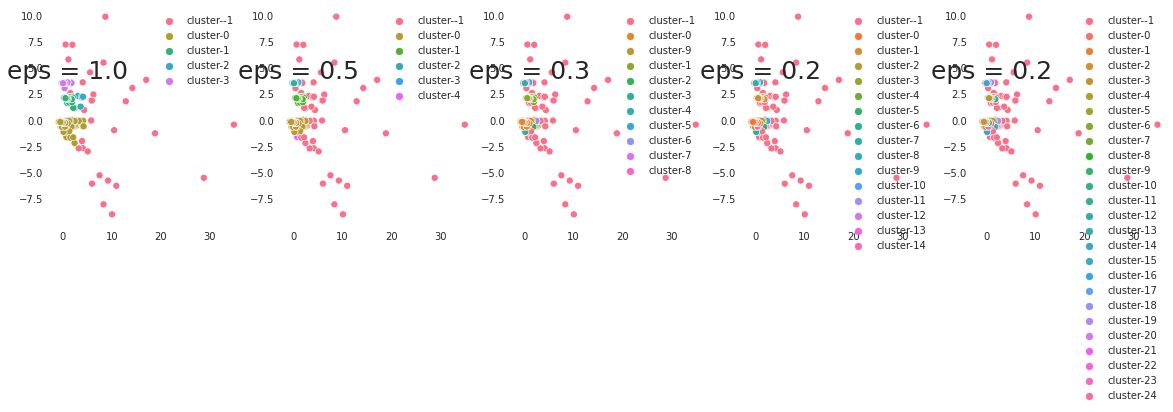

In [53]:
# eps visulization 

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(5, 0, -1):
    eps = 1/(6-x)
    db = DBSCAN(eps=eps, min_samples=4).fit(data_clus)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=25, ha="center")
    sns.scatterplot(data_clus[:,0], data_clus[:,1], hue=["cluster-{}".format(x) for x in labels]);
    
    i += 1

### **Sklearn's NearestNeighbors to determine eps:**
The optimal value for epsilon will be found at the point of maximum curvature.

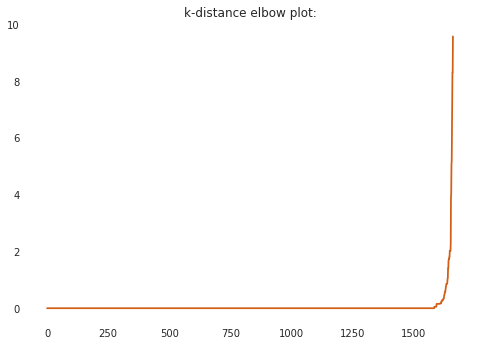

In [56]:
#Trying to find the eps given our data using NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(data_clus)
distances, indices = neighbors_fit.kneighbors(data_clus)

distances = np.sort(distances, axis=0)
distances = distances[:,1]


plt.title('k-distance elbow plot:')
plt.plot(distances,color = '#D15E14');


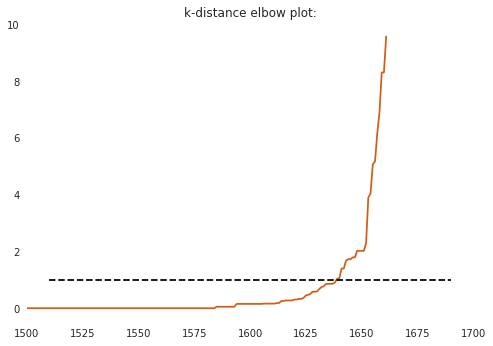

In [57]:
# Zoom in plot
plt.title('k-distance elbow plot:')

plt.plot(distances, color='#D15E14')
plt.axhline(y=1, color='k', linestyle='--',xmin=0.05,xmax=0.95)
plt.xlim(1500, 1700)

plt.show();


Using the following paper's method for detecting the elbow point (or knee point):
 “Finding a “Kneedle” in a Haystack: Detecting Knee Points in System Behavior”

In [ ]:
#Download The library:
!pip install kneed

0.0


<Figure size 360x360 with 0 Axes>

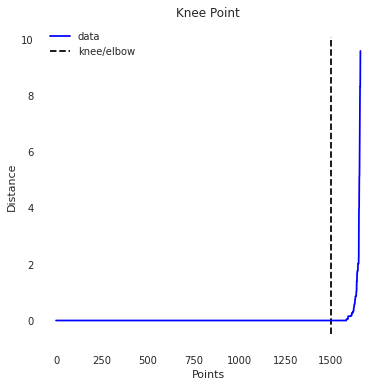

In [ ]:

from kneed import KneeLocator
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")

print(distances[knee.knee])

## **Final results**

In [58]:
joined_Users.sample(2)

,Number_of_Orders,Total_Payment,Cash,Card,STC_Pay,Common_ProdcutCat_Count,Common_ProdcutCat,pred_cluster,pred_cluster_DBSCAN
OtherUserId,,,,,,,,,
2579,4.0,60.0,3.0,1.0,0.0,1,{Gift and flowers},0,0
5685,1.0,0.0,0.0,0.0,0.0,1,{Food},0,0


### **Kmean results**

In [ ]:
joined_Users.groupby('pred_cluster').agg({"Number_of_Orders":['sum','median','mean'],"Total_Payment":['sum','median','mean'],"Cash":['sum','median','mean'],"Card":['sum','median','mean'],"STC_Pay":['sum','median','mean'],"Common_ProdcutCat":['count']})


Number_of_Orders         ...   STC_Pay Common_ProdcutCat
                          sum median  ...      mean             count
pred_cluster                          ...                            
0                      2072.0    1.0  ...  0.000000              1529
1                       232.0    3.0  ...  0.032787                61
2                        93.0   46.5  ...  0.500000                 2
3                       219.0   15.0  ...  0.166667                12
4                       100.0    1.0  ...  1.034483                58

[5 rows x 16 columns]

### **K-means Insights:**
Given a time frame of 6 months.
### **CLUSTER 0:-** 
**Number of Orders:**
 The number of orders for customers in cluster 0 is an average of 1 order with a total of 2072.

**Total payment:**
The average of the total payment for customers in cluster 0 is 23.9 riyal with a total of 36630 riyal in 6 months.

**Cash:**
The total number of orders paid cash in cluster 0 is 945.

**Card:**
The total number of orders paid using a card in cluster 0 is 165.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 0 is 0.

<br> </br>

### **CLUSTER 1:-**
**Number of Orders:**
 The number of orders for customers in cluster 1 is an average of 46 order with a total of 93.

**Total payment:**
The average of the total payment for customers in cluster 1 is 1110 riyal with a total of 2220 riyal in 6 months.

**Cash:**
The total number of orders paid cash in cluster 1 is 39.

**Card:**
The total number of orders paid using a card in cluster 1 is 18.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 1 is 1.

<br> </br>

### **CLUSTER 2:-**
**Number of Orders:**
 The number of orders for customers in cluster 2 is an average of 13 orders with a total of 83 in 6 months.

**Total payment:**
 The average of the total payment for customers in cluster 2 is 180 riyal with a total of 1080 riyal.

**Cash:**
The total number of orders  paid cash in cluster 2 is 4.

**Card:**
The total number of orders paid using a card in cluster 2 is 79.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 2 is 0.

<br> </br>

### **CLUSTER 3:-**
**Number of Orders:**
 The number of orders for customers in cluster 3 is an average of 34 orders with a total of 173 in 6 months.

**Total payment:**
 The average of the total payment for customers in cluster 3 is 882 riyal with a total of 4410 riyal.

**Cash:**
The total number of orders paid cash in cluster 3 is 73.

**Card:**
The total number of orders paid using a card in cluster 3 is 21.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 3 is 3.

<br> </br>

### **CLUSTER 4:-** 

**Number of Orders:**
 The number of orders for customers in cluster 4 is an average of 4 orders with a total of 269 in 6 months.

**Total payment:**
 The average of the total payment for customers in cluster 4 is 64.8 riyal with a total of 4020 riyal.

**Cash:**
The total number of orders paid cash in cluster 4 is 122.

**Card:**
The total number of orders paid using a card in cluster 4 is 21.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 4 is 2.

<br> </br>


### **Conclusion:**
Using the K-means algorithm with a cluster count of 5 we see that the customers in cluster 1 prefer to pay using STCPay rather than card or cash in comparision to the other 4 clusters. In contrast customers in cluster 0 prefer to pay with cash the most.Cluster 0 also has the higehst number of orders with 2091 orders while cluster 4 has 83 orders, being the least amount of orders out of the 5 clusters.In terms of profit cluster 0 generates the app the most amount of profit followed by cluster 3,2,1, and 4.





### **DBSCAN results**

In [ ]:
joined_Users.groupby('pred_cluster_DBSCAN').agg({"Number_of_Orders":['sum','median','mean'],"Total_Payment":['sum','median','mean'],"Cash":['sum','median','mean'],"Card":['sum','median','mean'],"STC_Pay":['sum','median','mean'],"Common_ProdcutCat":['count']})

Number_of_Orders         ... STC_Pay Common_ProdcutCat
                                 sum median  ...    mean             count
pred_cluster_DBSCAN                          ...                          
-1                             429.0   10.5  ...     0.4                30
 0                            2053.0    1.0  ...     0.0              1526
 1                             125.0    2.0  ...     0.0                48
 2                              26.0    5.0  ...     0.0                 5
 3                              83.0    1.0  ...     1.0                53

[5 rows x 16 columns]

### **DBSCAN Insights:**
Given a time frame of 6 months.
### **CLUSTER -1:-** 
**Number of Orders:**
The number of orders for customers in cluster -1 is an average of 14 orders with a total of 429.

**Total payment:**
The average of the total payment for customers in cluster -1 is 270 riyal with a sum of 8100 riyal in 6 months.

**Cash:**
The total number of orders paid cash in cluster -1 is 163.

**Card:**
The total number of orders paid using a card in cluster -1 is 134.

**STC_Pay:**
The total number of orders paid using STCPay in cluster -1 is 12.

<br> </br>

### **CLUSTER 0:-**
**Number of Orders:**
 The number of orders for customers in cluster 0 is an average of 1 order with a total of 2053 in 6 months.

**Total payment:**
The average of the total payment for customers in cluster 0 is 23.6 riyal with a total of 36030 riyal in 6 months.

**Cash:**
The total number of orders paid cash in cluster 0 is 949.

**Card:**
The total number of orders paid using a card in cluster 0 is 151.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 0 is 0.

<br> </br>

### **CLUSTER 1:-**
**Number of Orders:**
 The number of orders for customers in cluster 1 is an average of 2 orders with a total of 125 in 6 months.

**Total payment:**
 The average of the total payment for customers in cluster 1 is 37.5 riyal with a total of 1800 riyal.

**Cash:**
The total number of orders paid cash in cluster 1 is 37.

**Card:**
The total number of orders paid using a card in cluster 1 is 8.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 1 is 0.

<br> </br>


### **CLUSTER 2:-** 
**Number of Orders:**
 The number of orders for customers in cluster 2 is an average of 5 orders with a total of 26 in 6 months.

**Total payment:**
 The average of the total payment for customers in cluster 2 is 96 riyal with a total of 480 riyal.

**Cash:**
The total number of orders paid cash in cluster 2 is 23.

**Card:**
The total number of orders paid using a card in cluster 2 is 2.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 2 is 0.

<br> </br>


### **CLUSTER 3:-** 

**Number of Orders:**
 The number of orders for customers in cluster 3 is an average of 1 order with a total of 83 in 6 months.

**Total payment:**
 The average of the total payment for customers in cluster 3 is 24.9 riyal with a total of 1320 riyal.

**Cash:**
The total number of orders paid cash in cluster 3 is 28.

**Card:**
The total number of orders paid using a card in cluster 3 is 1.

**STC_Pay:**
The total number of orders paid using STCPay in cluster 3 is 53.

<br> </br>


### **Conclusion:**

Using the DBSCAN algorithm with a cluster count of 5 we see that the customers in cluster 3 prefer to pay using STCPay rather than card or cash in comparision to the other 4 clusters. In contrast customers in cluster 0 prefer to pay with cash the most.Cluster 0 also has the higehst number of orders with 2053 orders while cluster 2 has 26 orders, being the least amount of orders out of the 5 clusters.In terms of profit cluster 0 generates the app the most amount of profit followed by cluster -1,2,3, and 2.

### **Save results**

In [ ]:
joined_Users.to_csv('Customers_Clusters.csv')